# Bozza Random forest

Random forest fatta così non ha un cazzo di senso.
Avrà senso aggiungere la Z insieme ai dati e fare un unico grande dataset.
Dopodiche si può fare PCA, per scartare le componenti a due a due mega correlate, visto che rappresenteranno più o meno la stessa grandezza fisica.
Così possiamo ridurre il numero di features e rimane computaizonemlmente meno intensivo.

Altra cosa Mrem secondo me è una buona feature che racchiude varie cose, Dipende da Z, natal kick, m1, m2.

#### qui sopra non si è mai trattato di metallicità. qui sotto inserisco la metallicità in ogni dataset e li unisco tutti e rifaccio l'algoritmo

In [38]:
import pandas as pd
import os


heade = ['M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed', 'Mrem', 'Srem', 'esca_v', 'Mtot', 'gen']

path_data = './data/'
dyn = '/Dyn/' # Direi che così è facilmente customizzabile per come ogni autistic* si è sistemato i files.

In [27]:
def extractor(path_data, cluster):
    data = pd.DataFrame()
    wichcluster = os.listdir(path_data)
    #print(wichcluster)
    if cluster == 'gc':
        cluster = wichcluster[2]
    if cluster == 'nsc':
        cluster = wichcluster[1]
    if cluster == 'ysc':
        cluster = wichcluster[0]
    for i in os.listdir(path_data + cluster + dyn):
        #print(i)
        name = path_data + cluster + '/Dyn/' + str(i) + '/nth_generation.txt'
        #print(name)
        dataZ=pd.read_csv(name, delimiter=' ', skiprows=1, header=None)#, names=heade)
        dataZ.drop(dataZ.columns[[0, 5, 6, 7, 8, 10, 11, 12, 14, 18, 19, 20, 21, 22, 23, 24, 26]], axis=1, inplace=True)
        dataZ.columns = heade
        dataZ['Z'] = float(i)
        data = pd.concat([data, dataZ])
    return data

In [28]:
dgc = extractor(path_data, 'gc')

In [29]:
df = dgc.sample(frac=0.1)
print(df.dtypes)

M1           float64
M2           float64
S1           float64
S2           float64
t_pair       float64
t_elapsed    float64
Mrem         float64
Srem         float64
esca_v       float64
Mtot         float64
gen            int64
Z            float64
dtype: object


#### PCA

In [39]:
heade = heade + ['Z']

['M1',
 'M2',
 'S1',
 'S2',
 't_pair',
 't_elapsed',
 'Mrem',
 'Srem',
 'esca_v',
 'Mtot',
 'gen',
 'Z']

In [52]:
def normer_col(df,i):
    media = df[i].mean()
    std = df[i].std()
    coso = (df[i] - media)/std
    return coso

0.9999999999999977

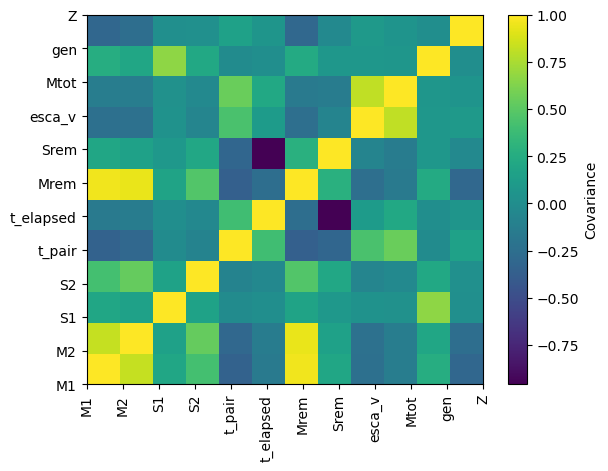

In [104]:
import matplotlib.pyplot as plt

matrix = np.zeros((len(heade), len(heade)))
for i in heade:
    a = heade.index(i)
    inorm = normer_col(df,i)
    for j in heade:
        #if i !=j:
        b = heade.index(j)
        jnorm = normer_col(df,j)
        #print(i,j)
        c = np.cov(inorm, jnorm)[0,1]
        #print(np.cov(inorm, jnorm)[0,1])
        matrix[b,a] = c
            
x, y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
x = x.flatten()
y = y.flatten()
values = matrix.flatten()

ticks = np.linspace(-0.5,11.5,1)
# Create a 2D histogram
plt.hist2d(x,y, weights=values, bins=(matrix.shape[1], matrix.shape[0]), cmap='viridis')
plt.colorbar(label='Covariance')
plt.xticks(ticks=np.arange(len(heade)), labels=heade, rotation=90)  # Tick for each bin, labeled with `heade`
plt.yticks(ticks=np.arange(len(heade)), labels=heade)
#plt.ylabel(heade.index())
plt.show()


Ora , siccome alta correlazione significa che le quantità indicano più o meno la stessa grandezza e viceversa bassissima sono l'una l'inverso dell'altra, seleziono le features che hanno una correlazione compresa tra abs(0.6).
Tipo si vede che M1 e M2 hanno la stessa identica relaziono con praticamente tutte le quantità, E sono fortemente correlate con Mrem, per cui si potrebbe ridurre le features tralasciando M2 e M1 e tenendo Mrem.  S1 ha una correlazione nulla con ciascuna feature, per cui non sembra eliminabile; stessa cosa per S2. 
Per Z vediamo che corrisponde alla teoria, è inversamente proporzionale alle masse e alla massa del remnant. Il t_pair, tempo di accoppiamento è giustamente inversamente proporzionale alle masse.
T_elapsed non lo so perchè sia fortemente inv-correlato con lo spin del remnant. Escape velocity è inversamente correlato alle singole masse e direttamente alla massa totale. La generazione del buco nero è debolmente correlata a tutto, tranne che allo spin. NOn so a livello fisico cosa faccia lo spin però.

### ML 

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
# Store feature importance results
feature_importances = {}
avg_importances_ysc = {}

for target_feature in list(df.columns):
    print(f'change feature, {target_feature}')
    # Define predictors (X) and target (y)
    X = df.drop(columns=[target_feature])
    y = df[target_feature]

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Random Forest model
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Store feature importance for the current target
    feature_importances[target_feature] = model.feature_importances_

# Convert to a DataFrame for easier interpretation
importance_df = pd.DataFrame(feature_importances, index=X.columns)

# Calculate average importance across all targets
importance_df["average_importance"] = importance_df.mean(axis=1)

# Sort features by average importance
sorted_importances = importance_df["average_importance"].sort_values(ascending=False)
print(sorted_importances)
#sorted_importances['Z-No correlation'] = i

avg_importances_ysc[i] = sorted_importances


change feature, M1
change feature, M2
change feature, S1
change feature, S2
change feature, t_pair
change feature, t_elapsed
change feature, Mrem
change feature, Srem
change feature, esca_v
change feature, Mtot
change feature, gen
change feature, Z
t_elapsed    0.232137
Mrem         0.206225
esca_v       0.157908
M1           0.109548
S1           0.105721
t_pair       0.071768
M2           0.038918
Mtot         0.027109
Srem         0.025694
S2           0.021633
gen          0.003339
Name: average_importance, dtype: float64


In [13]:
avg_importances_ysc = pd.DataFrame(avg_importances_ysc)
avg_importances_ysc.to_csv('ysc_importances_wZ.csv')

PCA